In [1]:
import json
from collections import defaultdict

# These data files are omitted from the git repository for user privacy
with open("conversation.json") as cnv:
    conversation = json.loads(cnv.read())
    members = conversation["members"]
with open("message.json") as msg:
    messages = json.loads(msg.read())

In [4]:
user_lookup = {
    user["user_id"]: user["name"] for user in members
}
liked_by_users = {
    user["user_id"]: defaultdict(int) for user in members
}
likes_per_users = {
    user["user_id"]: 0 for user in members
}

In [7]:
for message in messages: 
    sender = message["user_id"]
    liked_by = message["favorited_by"]
    
    if(sender == "system"):
        continue
    for like_er in liked_by:
        # If I like a message, it should increase my connection to the sender proportionally
        #     to the total number of likes I've awarded. We need to know who receives likes
        #     how many each person gives.
        liked_by_users[sender][like_er] += 1
        likes_per_users[like_er] += 1

In [8]:
import numpy as np
# Now we have to build an adjacency matrix :^) 

# Value x in (i, j) indicates a directed edge from i to j with weight x

adj_mat = np.zeros((len(user_lookup), len(user_lookup)))
for row_idx, (my_id, given_likes) in enumerate(likes_per_users.items()):
    for col_idx, (user_id, received_likes) in enumerate(liked_by_users.items()):
        
        weight = 0
        if(given_likes == 0):
            # this person doesn't like ANYONE
            pass
        else:
            # How many likes have they received by me, divided by all my likes
            weight = received_likes[my_id] / given_likes
        adj_mat[row_idx, col_idx] = weight

In [16]:
import markov_clustering as mc
from sklearn.manifold import TSNE
from scipy import stats

# Threshold the adjacencies:
adj_mat[adj_mat < 0.1] = 0
print(adj_mat)

# Use PCA as a quick dimensionality reduction for getting node positions
tsne = TSNE()
positions = tsne.fit_transform(adj_mat)

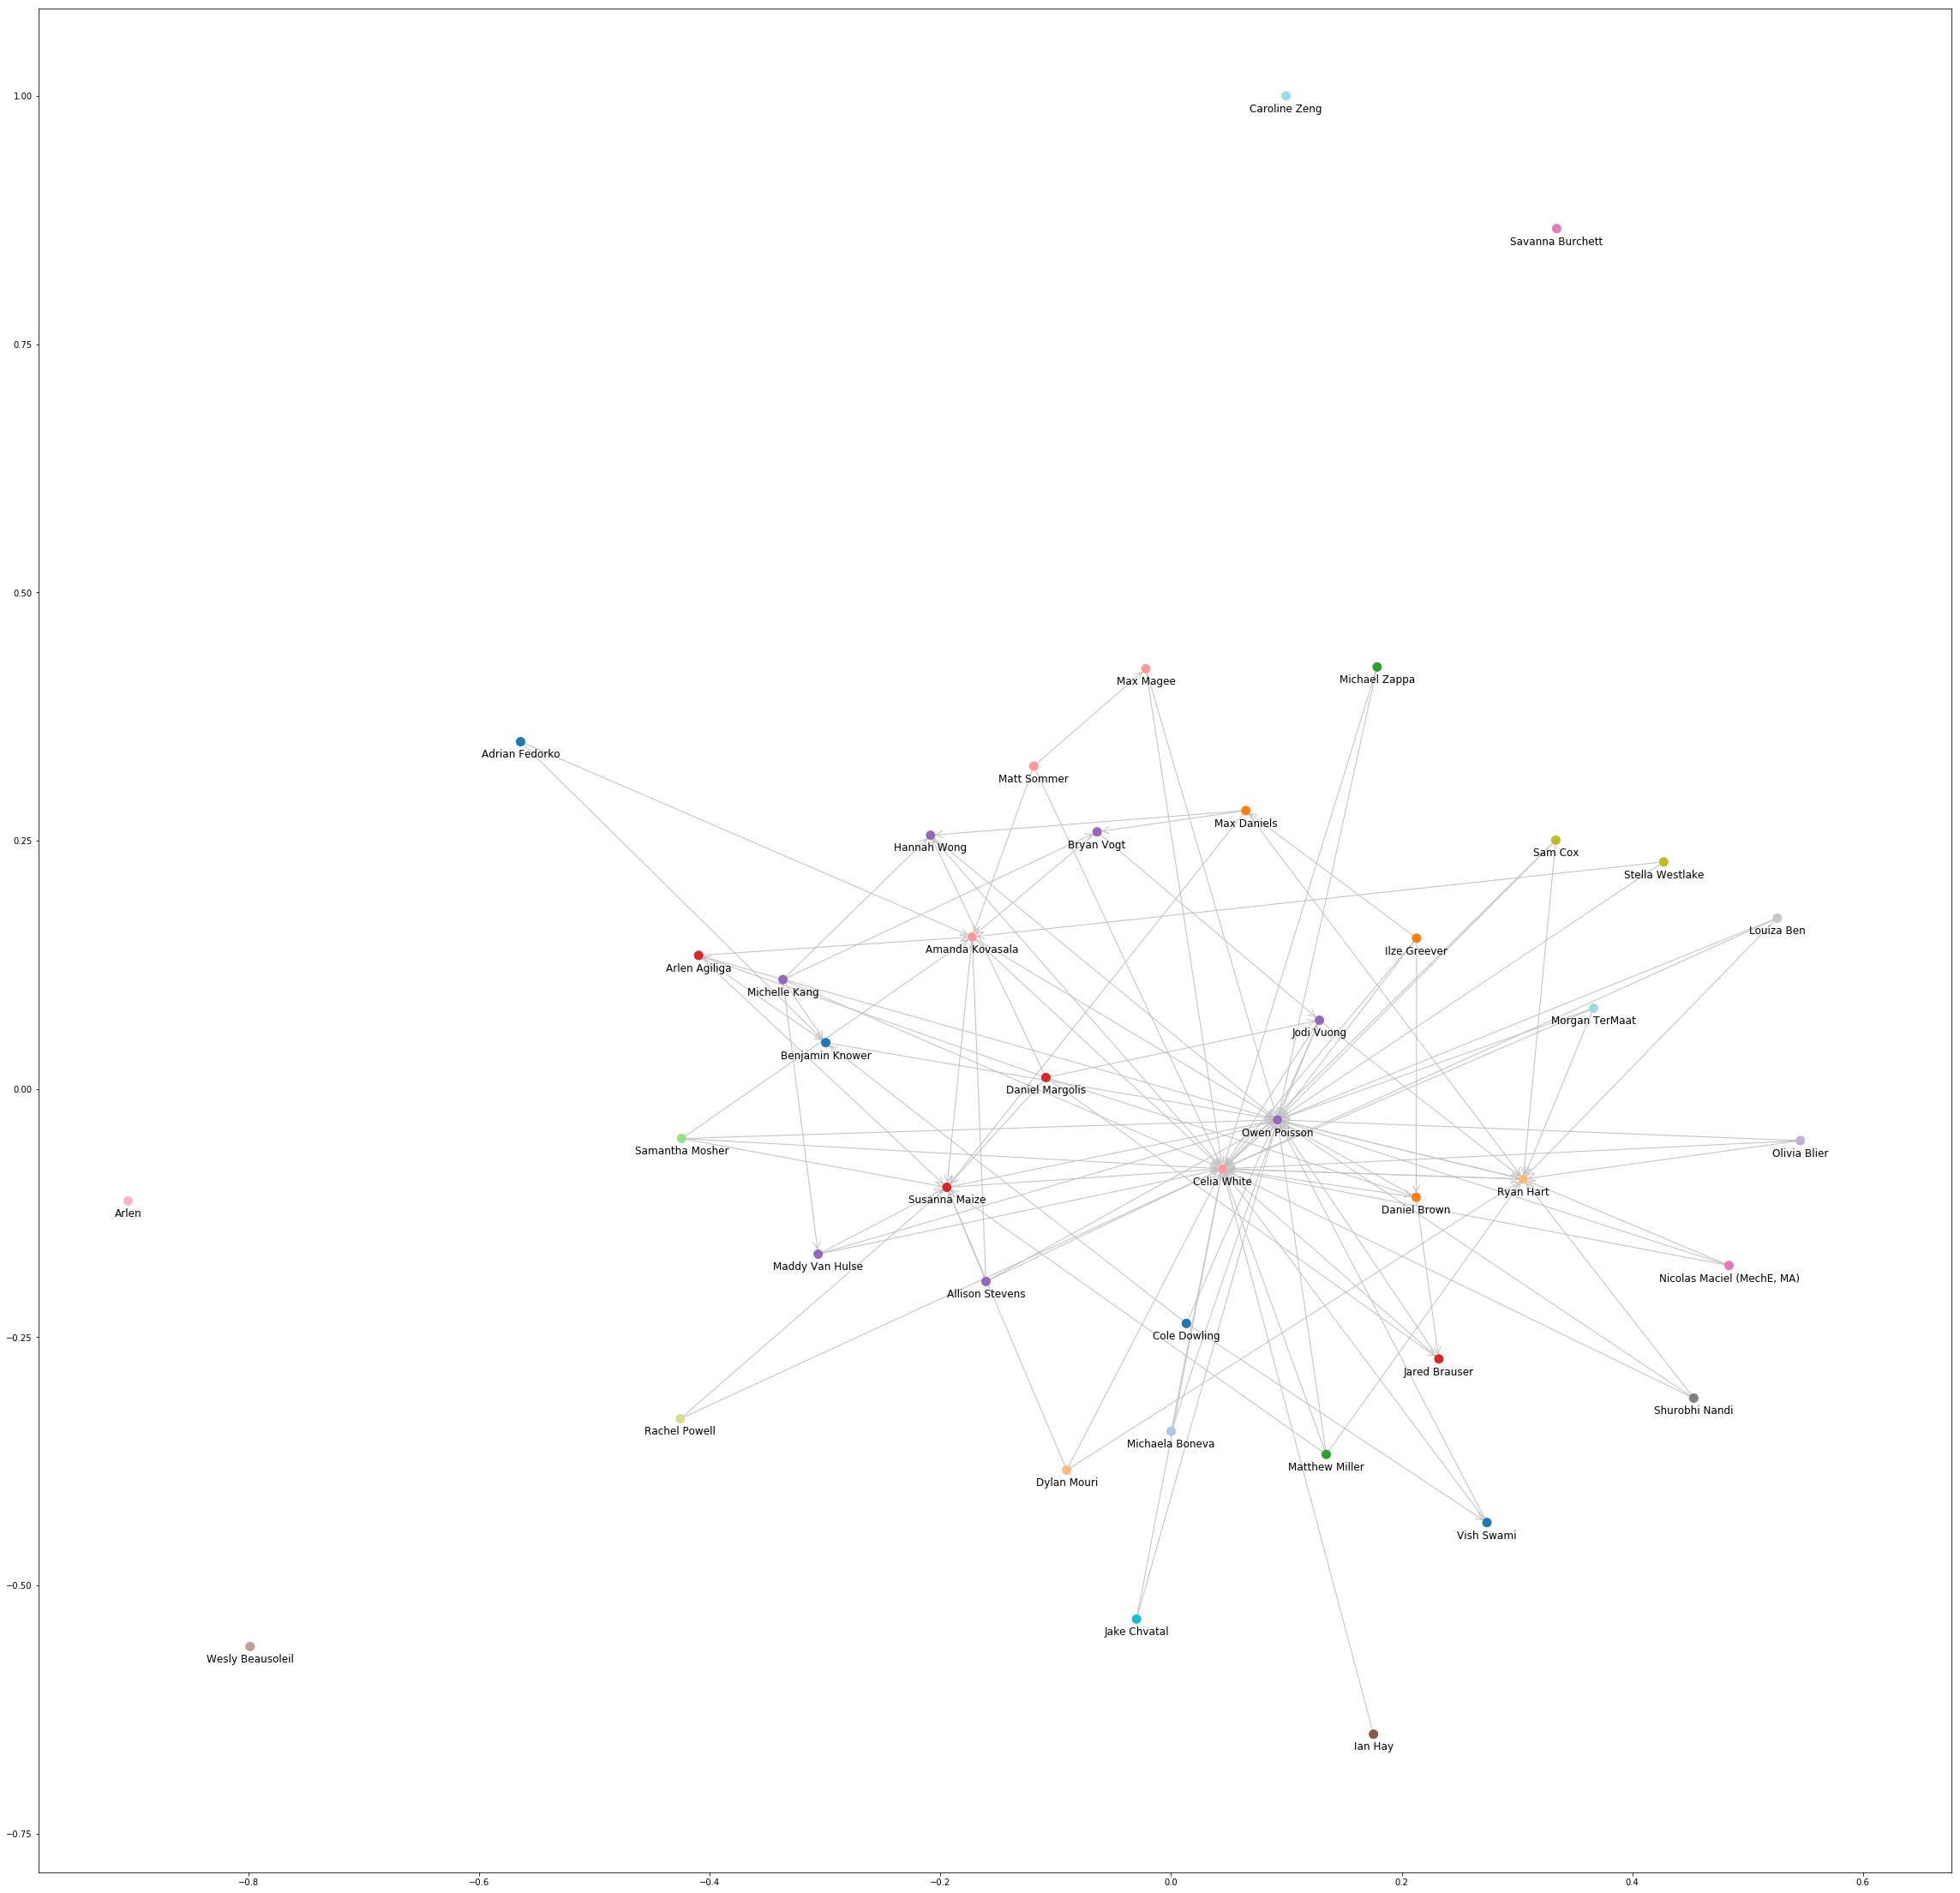

In [60]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pylab import show, cm, axis


graph = nx.DiGraph(adj_mat)
positions = nx.spring_layout(G, iterations=20)

names = { idx: "\n\n" + val for idx, val in enumerate(user_lookup.values()) }

mcl = mc.run_mcl(adj_mat, inflation=1.4)
clusters = mc.get_clusters(mcl)

cluster_map = {node: i for i, cluster in enumerate(clusters) for node in cluster}
colors = [cluster_map[i] for i in range(len(graph.nodes()))]
    
plt.figure(figsize=(40, 40))
nx.draw_networkx(graph,
                 node_color=colors,
                 cmap=cm.tab20,
                 pos=positions,
                 node_size=100,
                 with_labels=True,
                 labels=names,
                 edge_color="silver",
                 arrowstyle="->",
                 arrowsize=20)

plt.savefig("Friends_Graph.png")